In [7]:
from lsmulator import *
import numpy as np
import matplotlib.pyplot as plt
from figure_grid import *

In [2]:
z_ps = 1.25, 1.5, 2.
z_qs = [np.random.zipf(z, 50000) for z in z_ps]
trees = [lsmulate(queries) for queries in z_qs]

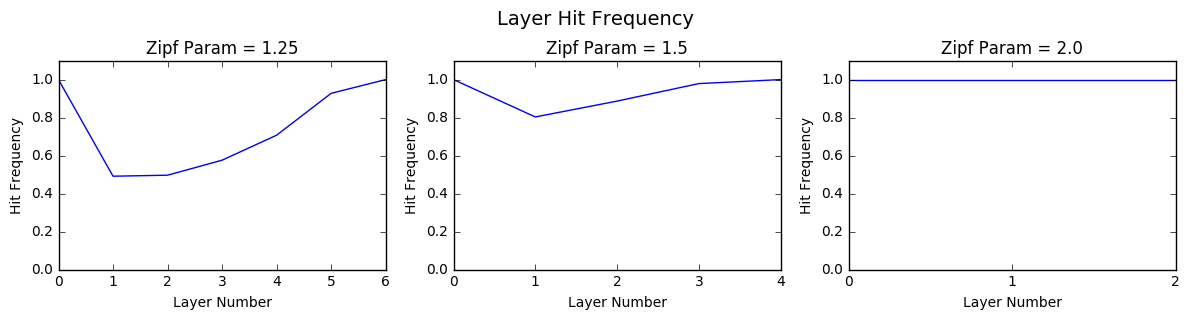

In [26]:
with figure_grid(1,3) as g:
  g.title('Layer Hit Frequency')
  for i, axis in enumerate(g.each_subplot()):
    layers = trees[i].layers()
    plt.title('Zipf Param = {}'.format(z_ps[i]))
    plt.ylim(0, 1.1)
    plt.ylabel('Hit Frequency')
    plt.xlabel('Layer Number')
    plt.xticks(range(len(layers)))
    plt.plot(range(len(layers)), [l.hit_frequency() for l in layers])

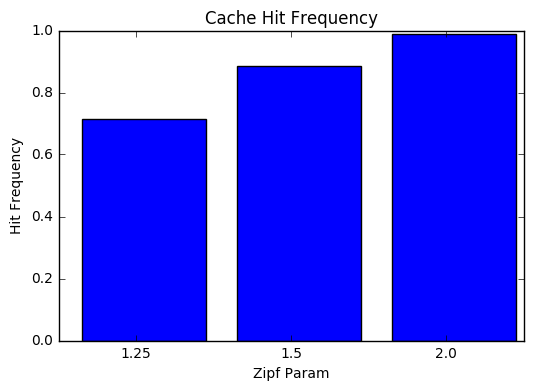

In [25]:
plt.title('Cache Hit Frequency')
plt.ylabel('Hit Frequency')
plt.bar(np.arange(len(trees))-0.35, [tree.cache.hit_frequency() for tree in trees])
plt.xticks(range(len(trees)), z_ps)
plt.xlabel('Zipf Param')
plt.show()